# 部分決定係数（partial R2）

Partial $R^2$ （偏決定係数、部分決定係数、偏重相関 などと呼ばれる）は Rosenbaum (2002) の改良として Imbens (2003)が提案した、線形回帰モデルにおける未観測の交絡因子の強さ（欠落変数バイアスの強さ）を把握する手法。


## 考え方

結果$Y$、処置$T$、未観測の交絡因子$U$それぞれに分布型を仮定してパラメトリックモデルを構築する。

### 1. 未観測の交絡因子$U$のモデル

未観測の交絡因子$U$は確率0.5のベルヌーイ分布に従うとする。つまり未観測の交絡因子が影響する/しないの値${1,0}$が$1/2$の確率で決まるとする。

$$
U_i \stackrel{\text { ind }}{\sim} \operatorname{Bern} \left(\frac{1}{2} \right)
$$

### 2. 処置変数$T$のモデル

処置$T$は二値変数で、ロジスティック回帰モデルで表現できると仮定する。観測済みの共変量$X$だけでなく、未観測の交絡$U$も影響するとして、処置$T$へ$\alpha$倍の強さで影響すると仮定する。

$$
T_i \mid X_i, U_i \stackrel{\text { ind }}{\sim} \operatorname{Bern}\left(\operatorname{sigmoid}\left(\gamma X_i+\alpha U_i\right)\right)
$$

別の書き方をすれば

$$
P(T_i = 1 \mid X_i, U_i) = \frac{ 1 }{ 1 + \exp( -(\gamma X_i + \alpha U_i) )}
$$

### 3. 結果変数$Y$のモデル

結果$Y$と他の変数との関係には正規線形回帰モデルを仮定する。未観測の交絡$U$は結果$Y$へ$\delta$倍の強さで影響すると仮定する。

$$
Y_i \mid X_i, T_i, U_i \stackrel{\text { ind }}{\sim} \mathcal{N}\left(\tau T_i+\beta X_i+\delta U_i, \sigma^2\right)
$$

別の書き方をすれば

$$
Y_i = \tau T_i + \beta X_i + \delta U_i + \varepsilon_i, \quad \varepsilon_i \sim \mathcal{N}(0, \sigma^2)
$$

となる。


### 推定

$U$は未観測だが、$\alpha, \delta$をなんらかの値に固定すれば、他のパラメータは最尤推定できる。

したがって、$\alpha, \delta$をさまざまな値に変えたもとでの推定を行うことで、

1. 未観測の交絡因子が割当や結果変数にどれくらい影響力があるか
2. 因果効果の推定値$\tau$がどの程度変化するか

を推定することができる

## 部分決定係数

未観測の交絡因子の影響を表す 部分決定係数（partial $R^2$）は推定したパラメータをもとに構成される。

:::{admonition} 部分決定係数

$Y$の部分決定係数$R^2_{Y, par}(\alpha, \delta)$は次のように定義される

$$
R^2_{Y, par}(\alpha, \delta)
= 1 - \frac{ RSS_{\text{full}} }{ RSS_{\text{reduced}} }
$$

- $RSS_{\text{full}}$：$U$を含むモデルの残差平方和
- $RSS_{\text{reduced}}$：$U$を含まない、観測した変数のみのモデルの残差平方和

:::

直感的な解釈としては「$U$を追加したことで説明できた部分がどれだけあるか」。$U$を追加して$\text{full}$モデルの説明力が$\text{reduced}$モデルより高くなれば、 $RSS_{\text{full}} < RSS_{\text{reduced}}$ になる。

なので、

- 未観測の交絡因子$U$の影響が **多い** 場合、$RSS_{\text{full}} < RSS_{\text{reduced}}$になり$R^2_{Y, par}(\alpha, \delta)$は **1に近づく**
- 未観測の交絡因子$U$の影響が **少ない** 場合、$RSS_{\text{full}} \approx RSS_{\text{reduced}}$になり$R^2_{Y, par}(\alpha, \delta)$は **0に近づく** 

ということになる。

→ ⚠️通常の決定係数は1に近いほどいいが、 **部分決定係数は0に近いほどよい** ことになる点に注意。


:::{card} Imbens (2003) に記載の方法

未観測の交絡因子$U$を入れた回帰モデル

$$
Y_i \mid X_i, T_i, U_i \sim \mathcal{N}\left(\tau T_i+\beta X_i+\delta U_i, \sigma^2\right)
$$

を最尤推定したときの残差の分散の推定量 $\hat{\sigma}^2(\alpha, \delta)$ （残差平方和？）をもとに

$$
R_Y^2(\alpha, \delta)= \frac{ 1-\hat{\sigma}^2(\alpha, \delta) }{ \frac{1}{N}\sum_i(Y_i - \bar{Y})^2 }
$$

という関数を構築する。$\alpha=0, \delta = 0$を仮定すれば$U$の影響がゼロになるので、「未観測の交絡因子がない」という仮定になる。

$Y$に対する部分決定係数$R^2_{Y, par}(\alpha, \delta)$は次のように定義される

$$
\begin{aligned}
R_{Y, \mathrm{par}}^2(\alpha, \delta) & =\frac{R_Y^2(\alpha, \delta)-R_Y^2(0,0)}{1-R_Y^2(0,0)} \\
& =\frac{\hat{\sigma}^2(0,0)-\hat{\sigma}^2(\alpha, \delta)}{\hat{\sigma}^2(0,0)}
\end{aligned}
$$

処置変数への影響は

$$
R_T^2(\alpha, \delta)
=\frac{\hat{\gamma}(\alpha, \delta)^{\prime} \boldsymbol{\Sigma}_X \hat{\gamma}(\alpha, \delta)+\alpha^2 / 4}
{\hat{\gamma}(\alpha, \delta)^{\prime} \boldsymbol{\Sigma}_{\mathrm{x}} \hat{\gamma}(\alpha, \delta)+\alpha^2 / 4+\pi^2 / 3}
$$

部分決定係数は

$$
R_{W, \mathrm{par}}^2(\alpha, \delta)=\frac{R_T^2(\alpha, \delta)-R_T^2(0,0)}{1-R_T^2(0,0)}
$$

:::

:::{dropdown} 詳細な計算方法（金本, 2024）

金本拓 (2024) にかかれていた計算方法。よくわからなかった

実際の計算方法はもう少し複雑なものになる。

3つのパターンの部分決定係数を算出する

(1) $Y \sim T \mid X$

$X$で条件づけた結果$Y$と処置$T$の関係について

$$
R_{Y \sim T \mid X}^2=1-\frac{R S S_{Y \sim T+X}}{R S S_{Y \sim X}}
$$

ここで

- $R S S_{Y \sim T+X}$：結果$Y$を処置$T$と共変量$X$で説明したモデルの残差平方和
- $R S S_{Y \sim X}$：結果$Y$を共変量$X$で説明したモデルの残差平方和

これは次のようにも表される
$$
R_{Y \sim T \mid X}^2=\frac{R_{Y \sim T+X}^2-R_{Y \sim X}^2}{1-R_{Y \sim X}^2}
$$

ここで

$$
R_{Y \sim T+X}^2=1-\frac{R S S_{Y \sim T+X}}{\frac{1}{n} \sum_{i=1}^n\left(Y_i-\bar{Y}\right)^2}\\
$$

$$
R_{Y \sim X}^2=1-\frac{R S S_{Y \sim X}}{\frac{1}{n} \sum_{i=1}^n\left(Y_i-\bar{Y}\right)^2}
$$


(2) $Y \sim U \mid X, T$

$X, T$で条件づけた結果$Y$と未観測の交絡因子$U$の関係について。

$$
R_{Y \sim U \mid X, T}^2=\frac{R_{Y \sim U+X+T}^2-R_{Y \sim X+T}^2}{1-R_{Y \sim X+T}^2}
$$

(3) $T \sim U \mid X$

$X$で条件づけたもとでの未観測の交絡因子$U$の処置$T$への影響

$$
R_{T \sim U \mid X}^2=\frac{R_{T \sim U+X}^2-R_{T \sim X}^2}{1-R_{T \sim X}^2}
$$


:::

In [13]:
# 人工データで試したときのメモ
import numpy as np
import pandas as pd

# 人工データの生成
n = 1000
np.random.seed(0)

tau = 3
beta = 5
alpha = 5
delta = 2

u = np.random.binomial(n=1, p=0.5, size=n)
t = np.random.binomial(n=1, p=0.5, size=n)
x = np.random.uniform(size=n) + alpha * u
e = np.random.normal(size=n)
y = tau * t + beta * x + delta * u + e

df = pd.DataFrame({"y": y, "t": t, "x": x})
# df.plot.scatter(x="x", y="y")

# 2つの回帰モデルをfitしてRSSを取得
import statsmodels.formula.api as smf
m_ytx = smf.ols(formula='y ~ t + x', data=df).fit()
m_yx = smf.ols(formula='y ~ x', data=df).fit()

# 金本(2024)の計算を真似したメモ
# rss_ytx = m_ytx.ssr
# rss_yx = m_yx.ssr

# r2_yt_x = 1 - rss_ytx / rss_yx
# r2_yt_x

# r2_ytx = 1 - rss_ytx / y.var()
# r2_yx = 1 - rss_yx / y.var()
# (r2_ytx - r2_yx) / (1 - r2_yx)

## 実装

PySensemakrパッケージが便利。

:::{card}
[PySensemakr: Sensitivity Analysis Tools for Regression Models in Python](https://pysensemakr.readthedocs.io/en/latest/)
:::

In [5]:
import sensemakr as smkr
import statsmodels.formula.api as smf

# loads data
darfur = smkr.load_darfur()
# runs regression model
reg_model = smf.ols(formula='peacefactor ~ directlyharmed + age + farmer_dar + herder_dar + '\
                    'pastvoted + hhsize_darfur + female + village', data=darfur)
darfur_model = reg_model.fit()

# Create a sensemakr object and print summary of results
darfur_sense = smkr.Sensemakr(model = darfur_model,
                              treatment = "directlyharmed",
                              benchmark_covariates = ["female"],
                              kd = [1,2,3])
darfur_sense.summary()

Sensitivity Analysis to Unobserved Confounding

Model Formula: peacefactor ~ directlyharmed + age + farmer_dar + herder_dar + pastvoted + hhsize_darfur + female + village

Null hypothesis: q = 1 and reduce = True 

-- This means we are considering biases that reduce the absolute value of the current estimate.
-- The null hypothesis deemed problematic is H0:tau = 0.0 

Unadjusted Estimates of ' directlyharmed ':
  Coef. estimate: 0.097
  Standard Error: 0.023
  t-value: 4.184 

Sensitivity Statistics:
  Partial R2 of treatment with outcome: 0.022
  Robustness Value, q = 1 : 0.139
  Robustness Value, q = 1 alpha = 0.05 : 0.076 

Verbal interpretation of sensitivity statistics:

-- Partial R2 of the treatment with the outcome: an extreme confounder (orthogonal to the covariates)  that explains 100% of the residual variance of the outcome, would need to explain at least 2.187 % of the residual variance of the treatment to fully account for the observed estimated effect.

-- Robustness Valu

/home/mitama/notes/.venv/lib/python3.10/site-packages/sensemakr/sensitivity_statistics.py:177: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (t_statistic ** 2 / (t_statistic ** 2 + dof))[0]  # extracts float
/home/mitama/notes/.venv/lib/python3.10/site-packages/sensemakr/sensitivity_statistics.py:177: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return (t_statistic ** 2 / (t_statistic ** 2 + dof))[0]  # extracts float


### 結果の読み方

> Sensitivity Statistics

の箇所に部分決定係数が表示されている

```
Sensitivity Statistics:
  Partial R2 of treatment with outcome: 0.022
  Robustness Value, q = 1 : 0.139
  Robustness Value, q = 1 alpha = 0.05 : 0.076 
```


- `Partial R2 of treatment with outcome`：部分決定係数
- `Robustness Value, q = 1`： **Robustness Value** は未観測の交絡因子が処置変数と結果変数に与える影響を定量的に測る指標。値が大きいほど影響を受けないことを示す。
    - 例えばRobustness Valueが0.1なら、処置変数と結果変数の両方の残差の分散のうち10%を説明するほどの未観測の交絡因子が存在しない限り、処置の結果への影響はロバストであるという意味。
- `Robustness Value, q = 1 alpha = 0.05`：統計的有意性も加味したもの。

### Contour plot

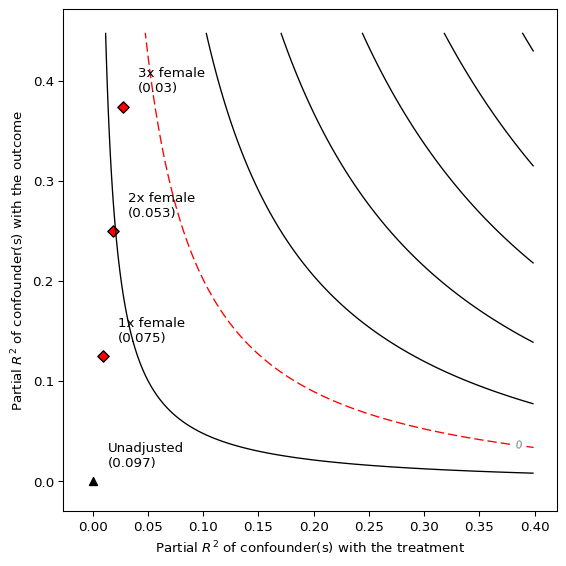

In [6]:
# contour plot for the estimate
darfur_sense.plot()

contour plotの見方

- x軸が処置変数の部分決定係数
- y軸が結果変数の部分決定係数
- 等高線：感度パラメーター（\alpha, \delta）の値のもとでのFullモデルで得られる、因果効果の調整済み推定値（adjusted estimate）
- 点：指定したcovariateの1倍、2倍、3倍の影響を持つ未観測の交絡因子のもとでの、因果効果の調整済み推定値（adjusted estimate）

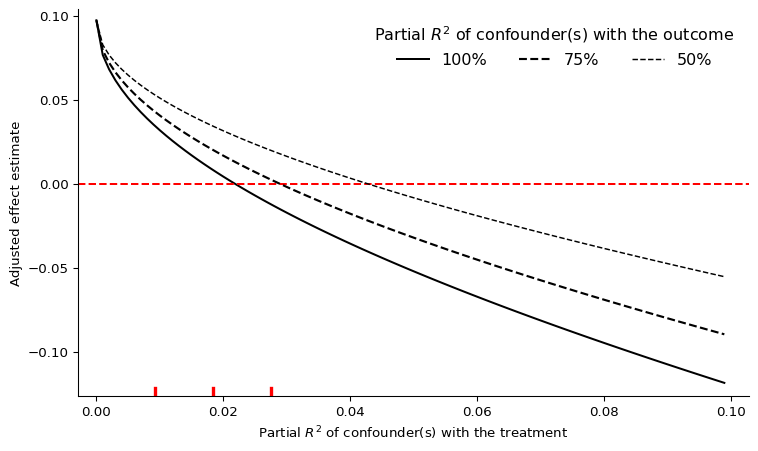

In [7]:
# extreme scenarios plot
darfur_sense.plot(plot_type = 'extreme')

## 発展手法

[Cinelli & Hazlett (2020)](https://academic.oup.com/jrsssb/article/82/1/39/7056023) は複数の交絡因子に対応するよう一般化した手法を提案し、 sensmakerパッケージとして提供


## 参考文献

- [Imbens, G. W. (2003). Sensitivity to exogeneity assumptions in program evaluation. American Economic Review, 93(2), 126-132.](https://www.aeaweb.org/articles?id=10.1257/000282803321946921)
- [Cinelli, C., & Hazlett, C. (2020). Making sense of sensitivity: Extending omitted variable bias. Journal of the Royal Statistical Society Series B: Statistical Methodology, 82(1), 39-67.](https://academic.oup.com/jrsssb/article/82/1/39/7056023)
- 星野崇宏. (2009). 調査観察データの統計科学: 因果推論・選択バイアス・データ融合.
- 金本拓. (2024). 因果推論: 基礎から機械学習・時系列解析・因果探索を用いた意思決定のアプローチ. 株式会社 オーム社.
